## Import and split data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import warnings
warnings.simplefilter('ignore')
bikes=pd.read_csv('train.csv', index_col=0, parse_dates=True)

In [190]:
from sklearn.model_selection import train_test_split

def dfSplitter(df):
    #split data to training and testing data sets 
    y=df['count']
    X=df.iloc[:, :10]
    xTrain, xTest, yTrain, yTest=train_test_split(X, y, train_size=0.8, random_state=42)
    return(xTrain, xTest, yTrain, yTest)

In [191]:
xTrain, xTest, yTrain, yTest=dfSplitter(bikes)

In [192]:
#remerge training data for EDA
dfTrain=pd.concat([yTrain, xTrain], axis=1)

## Cleanup data for EDA

In [4]:
def cleanerX(X):
    X['month']=X.index.month
    X['day']=X.index.weekday
    X['hour']=X.index.hour
    X['dayName']=X.index.day_name()

In [5]:
cleanerX(dfTrain)

## Exploratory Data Analysis (EDA)

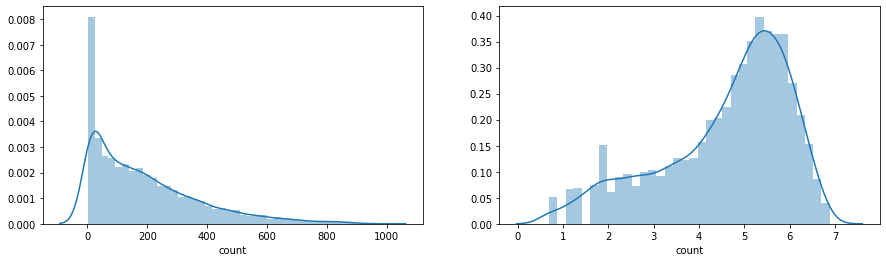

In [6]:
#take a look at count distribution vs log count 
fig, g=plt.subplots(1,2, figsize=(15,4))
sns.distplot(dfTrain['count'], ax=g[0])
sns.distplot(np.log1p(dfTrain['count']), ax=g[1])

**Taking the log of count seems to take away a good part of the skewness, something to consider doing when building model**

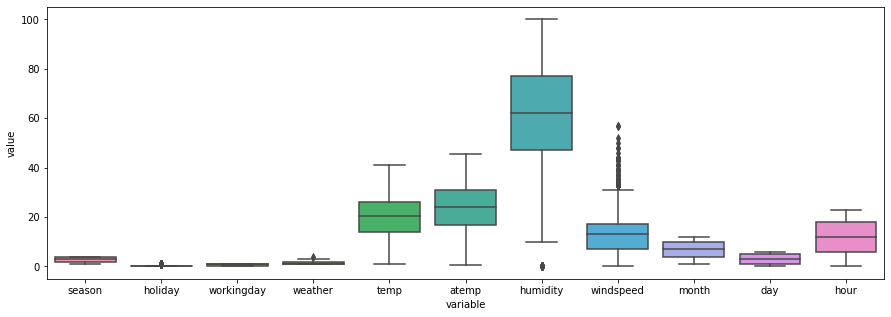

In [7]:
#take a look to see if there are any outliers 
plt.figure(figsize=(15,5))
sns.boxplot(x='variable', y='value', 
            data=pd.melt(dfTrain.drop(['count', 'casual', 'registered', 'dayName'], axis=1)))

**Outliers present in humidity and windspeed. If they are features to be included in the model then will have regularize the model**

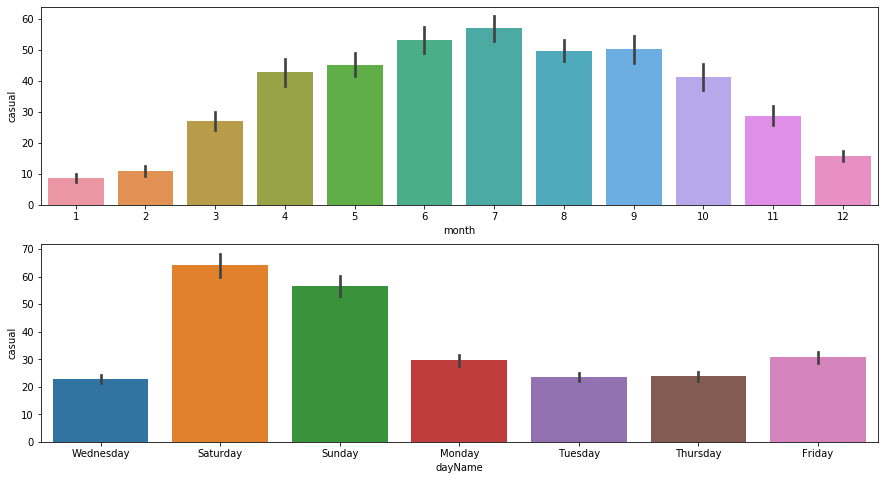

In [8]:
#take a look at monthly and daily usuage for casual riders 
fig, g=plt.subplots(2,1, figsize=(15,8))
sns.barplot(x='month', y='casual', data=dfTrain, ax=g[0])
sns.barplot(x='dayName', y='casual', data=dfTrain, ax=g[1])

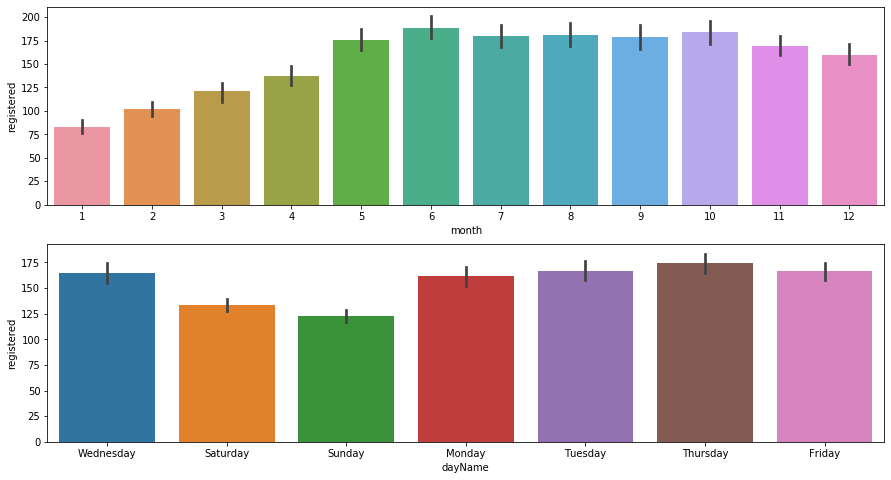

In [9]:
#take a look at monthly and daily usage for registered riders 
fig, g=plt.subplots(2,1, figsize=(15,8))
sns.barplot(x='month', y='registered', data=dfTrain, ax=g[0])
sns.barplot(x='dayName', y='registered', data=dfTrain, ax=g[1])

**More variability in bike rental with casual users in comparison to regular users**

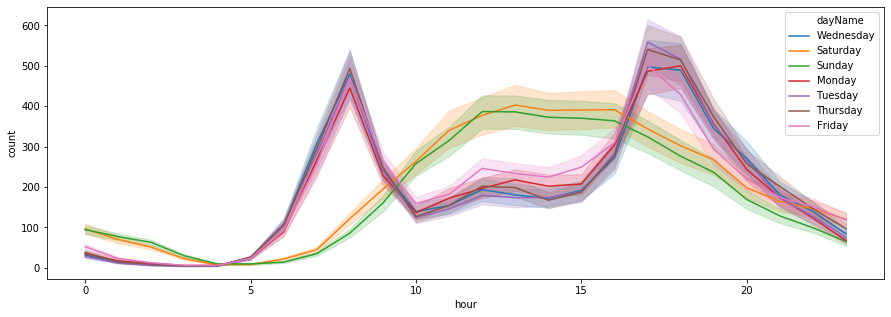

In [10]:
#take a look at hourly usage throughout the week for all riders 
plt.figure(figsize=(15,5))
sns.lineplot(x='hour', y='count', data=dfTrain, hue='dayName')

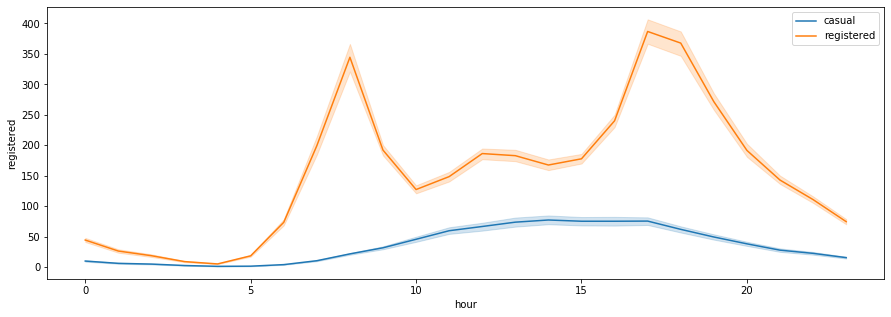

In [11]:
#take a look at daily hourly usage for casual vs registered riders 
plt.figure(figsize=(15,5))
sns.lineplot(x='hour', y='casual', data=dfTrain, label='casual')
sns.lineplot(x='hour', y='registered', data=dfTrain, label='registered')

**Consistent bike rental by casual users through out the week and time of day. Regular users peak usage during rush hour (going to and from work for example)**

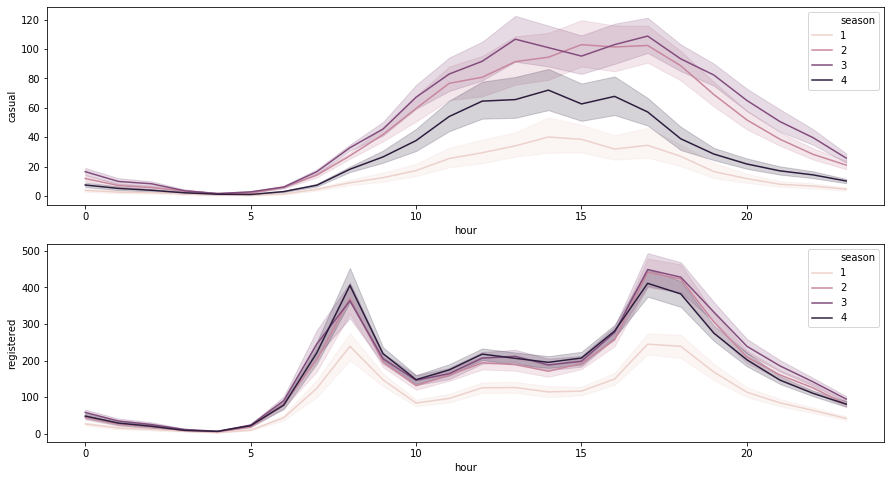

In [12]:
fig, g=plt.subplots(2,1, figsize=(15,8))
sns.lineplot(x='hour', y='casual', data=dfTrain, hue='season', ax=g[0])
sns.lineplot(x='hour', y='registered', data=dfTrain, hue='season', ax=g[1])

**Neither season nor weather play a role in bike rental for casual or regualr users**

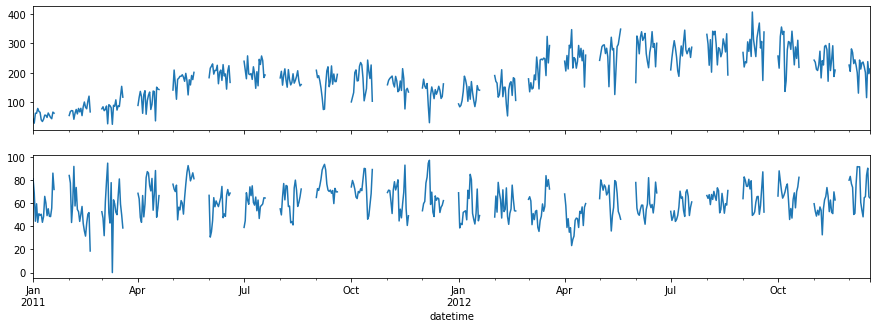

In [13]:
#compare bike usage to humidity changes throughout the year 
fig, g=plt.subplots(2,1,figsize=(15,5), sharex=True)
dfTrain['count'].resample('1D').mean().plot(ax=g[0])
dfTrain['humidity'].resample('1D').mean().plot(ax=g[1])

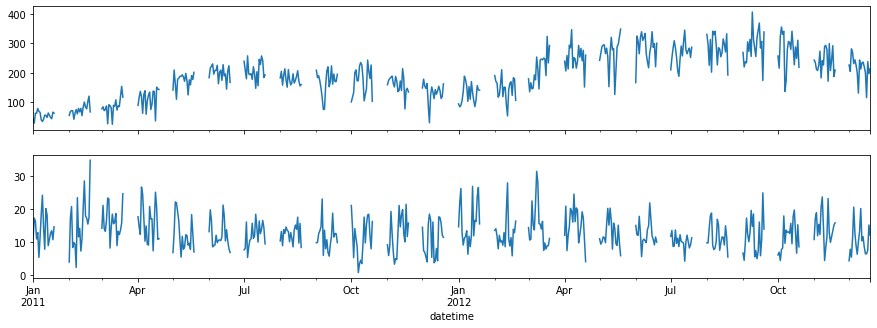

In [14]:
#compare bike usage throughout the year with wind conditions 
fig, g=plt.subplots(2,1,figsize=(15,5), sharex=True)
dfTrain['count'].resample('1D').mean().plot(ax=g[0])
dfTrain['windspeed'].resample('1D').mean().plot(ax=g[1])

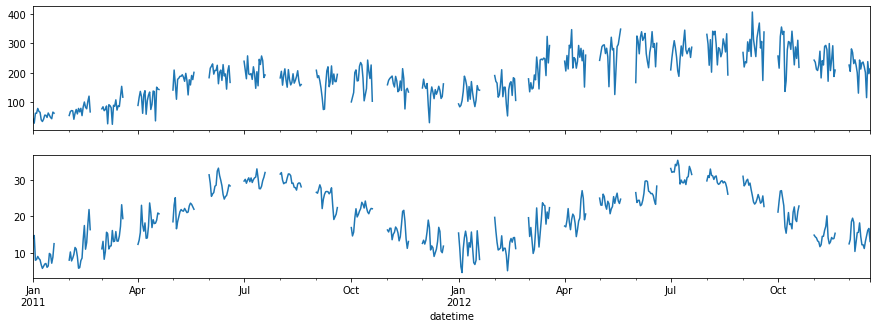

In [15]:
#compare bike usage throughout the year with temp fluctuations 
fig, g=plt.subplots(2,1,figsize=(15,5), sharex=True)
dfTrain['count'].resample('1D').mean().plot(ax=g[0])
dfTrain['temp'].resample('1D').mean().plot(ax=g[1])

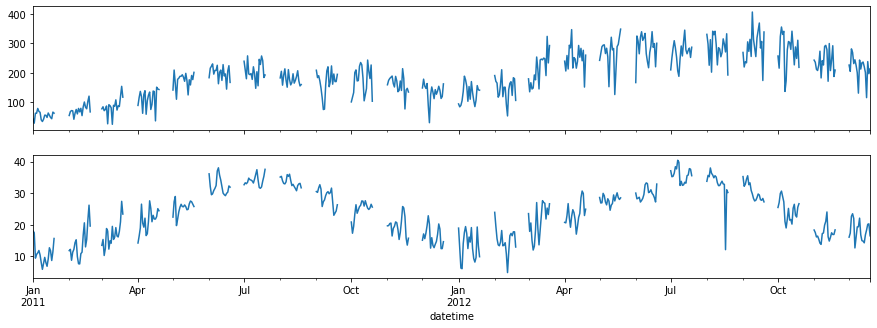

In [16]:
#compare bike usage with feeling temp fluctuations throughout the year 
fig, g=plt.subplots(2,1,figsize=(15,5), sharex=True)
dfTrain['count'].resample('1D').mean().plot(ax=g[0])
dfTrain['atemp'].resample('1D').mean().plot(ax=g[1])

**temperature and ambient temperature fluctuate similarly to bike count, indicate that plays a role in user count**

## Fetaure Selection

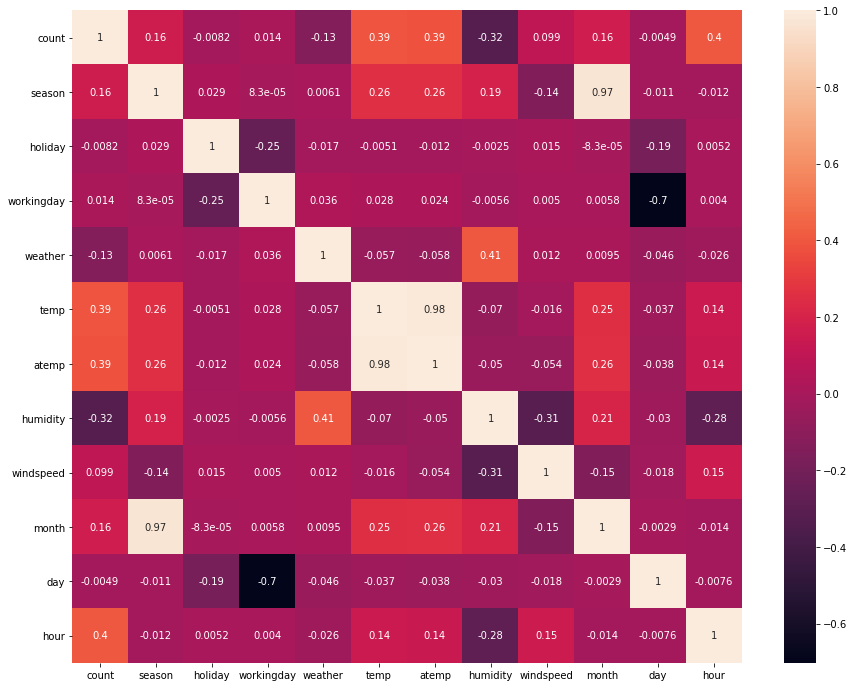

In [17]:
#examine which features correlate closests with each other 
plt.figure(figsize=(15, 12))
corr=dfTrain.drop(['casual', 'registered', 'dayName'],axis=1).corr()
sns.heatmap(corr, annot=True)

**apparent covariants: month/season and temp/atemp**

In [18]:
#select significant features 
from statsmodels.regression.linear_model import OLS
dfTrain['w0']=1
m=OLS(dfTrain['count'], 
      dfTrain[['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 
                'windspeed', 'casual', 'registered', 'month', 'day', 'hour', 'w0']])
resultM=m.fit()
featureTable= pd.DataFrame(round(resultM.pvalues, 5), 
                           index=dfTrain.drop(['count','casual','registered','dayName',
                            'w0'],axis=1).columns, 
                           columns=['feature pval']).sort_values('feature pval')
featureTable

,feature pval
holiday,0.00000
atemp,0.00000
humidity,0.00000
hour,0.00000
month,0.00002
workingday,0.00008
season,0.00185
temp,0.00229
weather,0.44976
windspeed,0.67689


In [20]:
X=dfTrain.drop(['count','casual','registered', 'w0', 'dayName'], axis=1)
y=dfTrain['count']
from sklearn.linear_model import LinearRegression
estimator=LinearRegression()
from sklearn.feature_selection import RFE
selector=RFE(estimator)
selector=selector.fit(X,y)
for feature, decision in zip(X.columns, selector.support_):
    print(feature, ':', decision)
featureTable= pd.DataFrame(selector.ranking_, index=X.columns, 
                                     columns=['feature importance']).sort_values('feature importance')
display(featureTable)

season : True
holiday : True
workingday : False
weather : False
temp : False
atemp : True
humidity : False
windspeed : False
month : True
day : False
hour : True


,feature importance
season,1
holiday,1
atemp,1
month,1
hour,1
humidity,2
weather,3
temp,4
workingday,5
windspeed,6


**From EDA and feature selection, the ones that are worth a try for modeling: hour, workingday,  atemp, humidity, month,  holiday and season**

## Feature Engineering I

#### Creating time peaks and interacting terms

In [193]:
cleanerX(xTrain)

In [194]:
def featEng(X):
    #creating month columns for peaks in june nad july 
    X['mJun']=np.abs(X['month']-6) 
    X['mJul']=np.abs(X['month']-7)
    #creating peak time columns
    X['8h']=np.abs(X['hour']-8)
    X['18h']=np.abs(X['hour']-18)
    #interaction terms 
    X['mJulHol']=X['mJul']*X['holiday']
    X['mJunWD']=X['mJun']*X['workingday']
    X['mJultemp']=X['mJul']*X['temp']
    X['mJulHum']=X['mJul']*X['humidity']
    return(X)

In [195]:
def featEng2(X,y):
    #remove problematic column
    X.drop(['dayName', 'casual', 'registered'], axis=1, inplace=True)
    #calculate log of count
    y=np.log1p(y+1)
    return(X,y)

In [196]:
xTrain=featEng(xTrain)

In [197]:
xTrain, yTrain=featEng2(xTrain, yTrain)

## Model tesing and evaluation II

In [201]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_log_error

def testMod(X, y, xIndex, modName, modType):
    r2List=[]
    rmsleList=[]
    X=X
    
    sns.lineplot(x=X.index.month, y=y, label='y True')
    for i in range(len(xIndex)):
        if modType=='LR':
            m=LinearRegression()
        elif modType=='DT':
            m=DecisionTreeRegressor()
        elif modType=='RF':
            m=RandomForestRegressor()
        X1=X[xIndex[i]] 
        m.fit(X1, y)
        r2=m.score(X1,y)
        r2List.append(r2)
        X['ypred']=m.predict(X1)
        sns.lineplot(x=X.index.month, y=X['ypred'], label=modName[i])
        rmsle=np.sqrt(mean_squared_log_error(y, X['ypred']))
        rmsleList.append(rmsle)
    plt.legend(loc='lower right')
    plt.show()
    r2Table=pd.DataFrame({'model':modName, '$r^2$':r2List, 'RMSLE':rmsleList})
    display(r2Table)

In [202]:
basic=['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
        'humidity', 'windspeed', 'month', 'day', 'hour']
edaList=['hour','atemp','humidity','month','season','workingday','holiday']
feList=['mJulHol','mJunWD','mJultemp','mJulHum', '8h', '18h']
xIndex=[basic, edaList, feList, edaList+feList, basic+edaList+feList]
modName=['noAnalysis', 'EDA', 'Interact', 'EDA+Interact', 'noAnalysis+EDA+Interact']

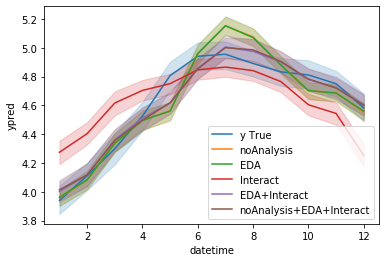

,model,$r^2$,RMSLE
0,noAnalysis,0.465875,0.214645
1,EDA,0.465314,0.214749
2,Interact,0.589365,0.199091
3,EDA+Interact,0.623849,0.192033
4,noAnalysis+EDA+Interact,0.628750,0.191273


In [203]:
##'LR'=LinearRegression, 'DT'=DecisionTree 'RF'=RandomForest
testMod(xTrain, yTrain, xIndex, modName, 'LR')

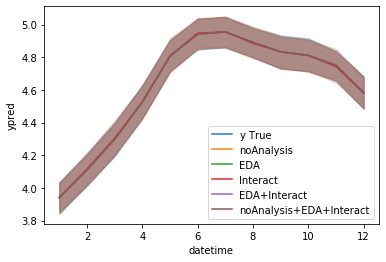

,model,$r^2$,RMSLE
0,noAnalysis,0.999994,0.000798
1,EDA,0.996537,0.016826
2,Interact,0.989819,0.030208
3,EDA+Interact,0.997199,0.015301
4,noAnalysis+EDA+Interact,0.999994,0.000798


In [137]:
##'LR'=LinearRegression, 'DT'=DecisionTree 'RF'=RandomForest
testMod(xTrain, yTrain, xIndex, modName, 'DT')

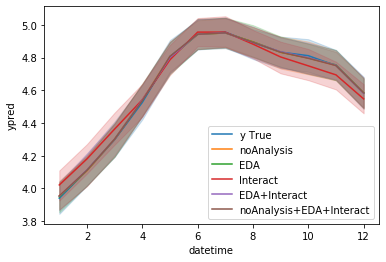

,model,$r^2$,RMSLE
0,noAnalysis,0.990499,0.031223
1,EDA,0.986028,0.036594
2,Interact,0.974542,0.048935
3,EDA+Interact,0.986680,0.036073
4,noAnalysis+EDA+Interact,0.990570,0.031125


In [138]:
##'LR'=LinearRegression, 'DT'=DecisionTree 'RF'=RandomForest
testMod(xTrain, yTrain, xIndex, modName, 'RF')

**When comparing linear regression, decision tree and random forest, the interacting features provide the greatest boost to the model. Decision tree overfitted the data. Random forest didn't overfit the model to the data as much**

## Feature Scaling II (Scaling Features)

In [171]:
#prepare new training and testing sets for scaling 
xTrain, xTest, yTrain, yTest=dfSplitter(bikes)
cleanerX(xTrain)
xTrain=featEng(xTrain)
xTrain, yTrain=featEng2(xTrain, yTrain)

In [172]:
from sklearn.preprocessing import StandardScaler

def dfScalar(X, y):
    #prepare a df for scaling 
    dfTrain=pd.concat([y, X], axis=1)
    ts=dfTrain.index  
    col=dfTrain.columns
    #perform scaling transformation
    sc=StandardScaler()
    dfTrain=sc.fit_transform(dfTrain)
    #convert numpy array back to df
    dfTrain=pd.DataFrame(dfTrain, columns=col, index=ts)
    ##seperate back to x y for modeling 
    X=dfTrain[col]
    X=X.drop('count', axis=1)
    y=dfTrain['count']
    return(X,y)

In [173]:
#scale all x and y features 
xTrain, yTrain=dfScalar(xTrain, yTrain)

In [174]:
#make sure use right columns for modeling 
xTrain.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'month', 'day', 'hour', 'mJun', 'mJul', '8h',
       '18h', 'mJulHol', 'mJunWD', 'mJultemp', 'mJulHum'],
      dtype='object')

In [175]:
basic=['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
        'humidity', 'windspeed', 'month', 'day', 'hour']
edaList=['hour','temp','humidity','month','season','workingday','holiday']
feList=['mJulHol','mJunWD','mJultemp','mJulHum', '8h', '18h']
xIndex=[basic, edaList, feList]
modName=['noAnalysis', 'EDA', 'Interact']

## Model Testing and Evaluation II (Scaling Features)

In [188]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_log_error

def testModScalar(X, y, xIndex, modName, modType):
    r2List=[]
    rmsleList=[]
    X=X
    
    sns.lineplot(x=X.index.month, y=y, label='y True')
    for i in range(len(xIndex)):
        if modType=='LR':
            m=LinearRegression()
        elif modType=='DT':
            m=DecisionTreeRegressor()
        elif modType=='RF':
            m=RandomForestRegressor()
        X1=X[xIndex[i]] 
        m.fit(X1, y)
        r2=m.score(X1,y)
        r2List.append(r2)
        X['ypred']=m.predict(X1)
        sns.lineplot(x=X.index.month, y=X['ypred'], label=modName[i])
##not sure why but only works when exponentiate both ytrue and ypreds
        y=np.exp(y)
        X['ypred']=np.exp(X['ypred'])
        rmsle=np.sqrt(mean_squared_log_error(y, X['ypred']))
        rmsleList.append(rmsle)
    plt.legend(loc='lower right')
    plt.show()
    r2Table=pd.DataFrame({'model':modName, '$r^2$':r2List, 'RMSLE':rmsleList})
    display(r2Table)

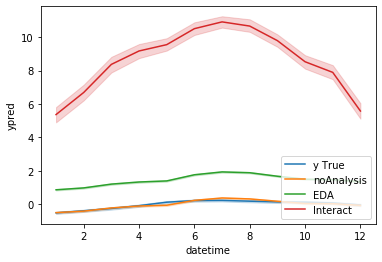

,model,$r^2$,RMSLE
0,noAnalysis,0.465875,0.340908
1,EDA,0.385245,0.713042
2,Interact,0.165972,13.530984


In [189]:
testModScalar(xTrain, yTrain, xIndex, modName, 'LR')

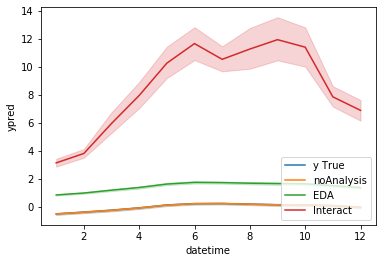

,model,$r^2$,RMSLE
0,noAnalysis,0.999994,0.001576
1,EDA,0.994253,0.071674
2,Interact,0.946797,3.443854


In [146]:
testModScalar(xTrain, yTrain, xIndex, modName, 'DT')

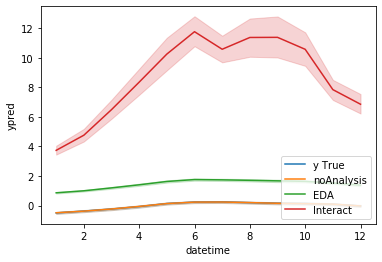

,model,$r^2$,RMSLE
0,noAnalysis,0.990550,0.045774
1,EDA,0.977665,0.140319
2,Interact,0.896277,4.806818


In [147]:
testModScalar(xTrain, yTrain, xIndex, modName, 'RF')

**Scaling the features didn't help improve the models, it was particularly detrimental to model with interacting terms.**